In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import pandas as pd

from config import key_id, secret_key



In [2]:
api = tradeapi.REST(key_id, secret_key)

In [3]:
#get data and turn to dataframe form
#15Min, 5Min
data=api.get_barset(symbols = ("INTC"), start = '2020-03-27T11:52:00-04:00', end = "2020-01-01", timeframe = "minute", limit=1000)
df=data.df #converts to dataframe

In [4]:
#get rid of multiindex, otherwise backtrader will have problems
df=df.INTC

In [5]:
#previewing
df.iloc[-10:-1]

,open,high,low,close,volume
2020-03-30 15:50:00-04:00,55.170,55.395,55.155,55.315,10518
2020-03-30 15:51:00-04:00,55.320,55.325,55.075,55.105,14968
2020-03-30 15:52:00-04:00,55.115,55.135,54.880,55.095,7689
2020-03-30 15:53:00-04:00,55.100,55.100,54.920,55.030,10386
2020-03-30 15:54:00-04:00,55.025,55.560,55.025,55.560,21469
2020-03-30 15:55:00-04:00,55.555,55.635,55.445,55.600,6800
2020-03-30 15:56:00-04:00,55.650,55.650,55.545,55.615,8352
2020-03-30 15:57:00-04:00,55.635,55.670,55.545,55.580,6727
2020-03-30 15:58:00-04:00,55.595,55.595,55.240,55.420,8590


In [6]:
#feed dataframe to cerbro
datacere = bt.feeds.PandasData(dataname=df)

datacere

In [7]:
#create backtrader
cerebro = bt.Cerebro()

In [8]:
#feed strat to cerebro
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

            
class secondStrategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [9]:
#cerebro.addstrategy(SmaCross)
cerebro.addstrategy(secondStrategy)


0

In [10]:
#set up cerebro

cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=20)
cerebro.adddata(datacere)


In [11]:
#create plotinfo dict for plotting options
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [12]:
#change window settings
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 15  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

In [13]:
#adding another simple moving average line
#this is the backtrader built in indicator
sma = bt.indicators.SimpleMovingAverage(datacere, period=15)
sma.plotinfo.plotname = 'mysma'

In [14]:
# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.Returns, _name="ret")
#analyzers list and also creating own analyzer
#https://www.backtrader.com/docu/analyzers/analyzers/
#https://www.backtrader.com/docu/analyzers-reference/

<IPython.core.display.Javascript object>


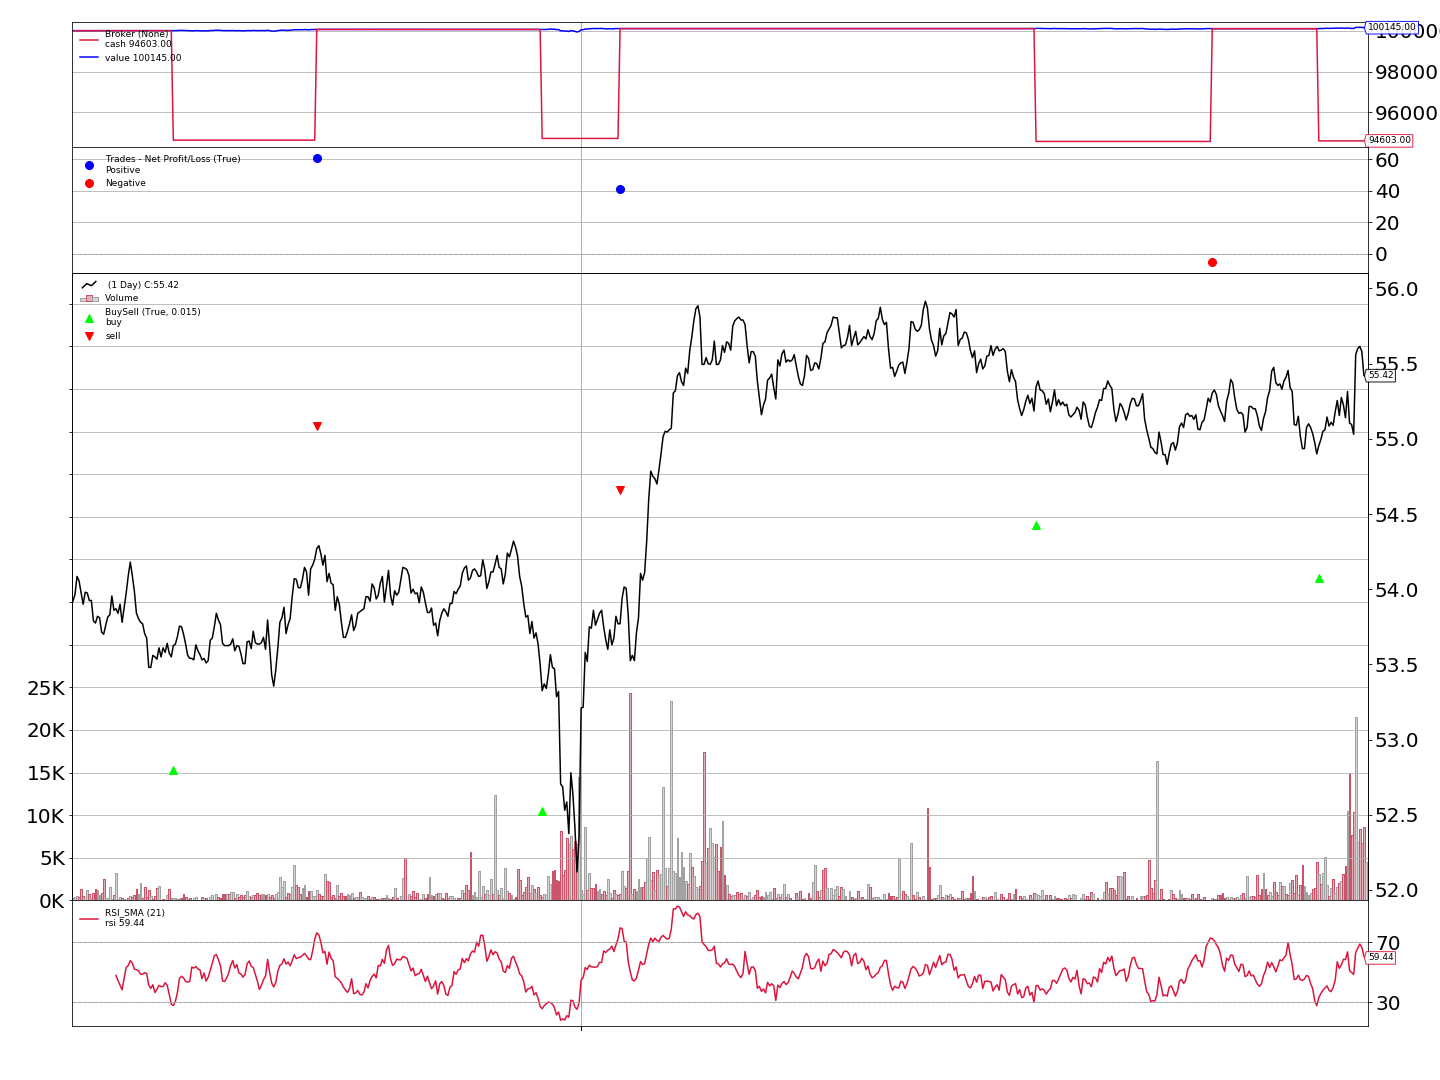

[[<Figure size 1440x1080 with 5 Axes>]]

In [29]:
# Run over everything
test=cerebro.run()

# Plot the result
cerebro.plot()


In [30]:
# print the SQN analyzers
#test[0] is the first strategy used. For multiple strategies, use corresponding number in the list.
SQN_dict=test[0].analyzers.sqn.get_analysis() 
tradeanalysis_dict=test[0].analyzers.ta.get_analysis()
ret_dict=test[0].analyzers.ret.get_analysis()

#.ta.get_analysis()
    #printSQN(firstStrat.analyzers.sqn.get_analysis())

    
#The Backtrader documentation provides a helpful ranking system for SQN:
#SQN measures the relationship between the mean (expectancy) and the standard deviation of the R-multiple distribution 
#generated by a trading system. It also makes an adjustment for the number of trades involved.
#    0 and under is BAD
#    1.6 – 1.9 Below average
#    2.0 – 2.4 Average
#    2.5 – 2.9 Good
#    3.0 – 5.0 Excellent
#    5.1 – 6.9 Superb
#    7.0 – Holy Grail?


In [31]:
SQN_dict

AutoOrderedDict([('sqn', 1.9999552575709763), ('trades', 3)])

In [32]:
ret_dict #in percentages

OrderedDict([('rtot', 0.0014489497651044385),
             ('ravg', 0.0007244748825522193),
             ('rnorm', 0.2002953726771724),
             ('rnorm100', 20.02953726771724)])

In [33]:
tradeanalysis_dict
#pnl stands for profit and loss

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 4), ('open', 1), ('closed', 3)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 2)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 1)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      96.50000000000105),
                                                     ('average',
                                                      32.16666666666702)])),
                                   ('net',
                                    AutoOrderedDict([('total',
                                      

In [34]:
tradeanalysis_dict.long

AutoOrderedDict([('total', 3),
                 ('pnl',
                  AutoOrderedDict([('total', 96.50000000000105),
                                   ('average', 32.16666666666702),
                                   ('won',
                                    AutoOrderedDict([('total',
                                                      102.00000000000102),
                                                     ('average',
                                                      51.00000000000051),
                                                     ('max',
                                                      61.000000000000654)])),
                                   ('lost',
                                    AutoOrderedDict([('total',
                                                      -5.499999999999972),
                                                     ('average',
                                                      -5.499999999999972),
                               

# Using a different Backtrader


In [21]:
#adding another backtrader
import bt as bt1

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [22]:
s = bt1.Strategy('s1', [bt1.algos.RunDaily(),
                       bt1.algos.SelectAll(),
                       bt1.algos.WeighEqually(),
                       bt1.algos.Rebalance()])

In [23]:
# create a backtest and run it
test = bt1.Backtest(s, df)
res = bt1.run(test)

s1
0% [############################# ] 100% | ETA: 00:00:00

In [24]:
res.display()

Stat                 s1
-------------------  -------------------------------------------
Start                2020-03-26
End                  2020-03-30
Risk-free rate       0.00%

Total Return         150.64%
Daily Sharpe         9.55
Daily Sortino        128.40
CAGR                 273963735609121727755149630120879194112.00%
Max Drawdown         -76.03%
Calmar Ratio         3603207996835795437684392826870169600.00

MTD                  -
3m                   -
6m                   -
YTD                  150.64%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  273963735609121727755149630120879194112.00%

Daily Sharpe         9.55
Daily Sortino        128.40
Daily Mean (ann.)    109586.57%
Daily Vol (ann.)     11469.69%
Daily Skew           -
Daily Kurt           -
Best Day             945.77%
Worst Day            -76.03%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly S

In [25]:
# first let's see an equity curve
res.plot()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [26]:
# ok and what about some stats?
res.stats

,s1
start,2020-03-26 11:52:00-04:00
end,2020-03-30 15:59:00-04:00
rf,0
total_return,1.50636
cagr,2.73964e+36
max_drawdown,-0.760333
calmar,3.60321e+36
mtd,NaN
three_month,NaN
six_month,NaN


In [27]:
#store gains and losses
#return distribution look like?
res.plot_histogram()

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


In [28]:
# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()